#Загрузка данных

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss, roc_auc_score

In [3]:
data = pd.read_csv('/content/drive/MyDrive/recsys/data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [4]:
# убираем дубликаты из датасета
data.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [5]:
#убираем неиспользуемые колонки
#campaign_clicks не нужна по условию задания
#impressions - потому что до этого было выяснено, что там везде одни и те же значения
data.drop(columns=['campaign_clicks', 'impressions'], inplace=True)
data.head()

,date_time,zone_id,banner_id,oaid_hash,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1


#Анализ данных и уже имеющихся фичей

1)date_time - время показа рекламы

2)oaid_hash - хэш юзера

3)zone_id - id зоны, где зона - место на сайте для размещения рекламы

4)banner_id - id баннера, где баннер - сама реклама

5)os_id - id операционной системы

6)country_id - id страны

7)banner_id0 - нулевой баннер в “стакане” баннеров

8)banner_id1 - первый баннер в “стакане” баннеров

9)rate0 - стоимость 1 клика установленная рекламодателем для banner_id0

10)rate1 - стоимость 1 клика установленная рекламодателем для banner_id1

11)g0 - стандартное отклонение предикта с banner_id0

12)g1 - стандартное отклонение предикта с banner_id1

13)coeff_sum0 - сумма коэффициентов для banner_id0

14)coeff_sum1 - сумма коэффициентов для banner_id1

15)clicks - был ли клик

In [6]:
# проверяем, есть ли отсутствующие значения в данных, считая количество null-ов
data.isnull().values.any()

True

In [7]:
#убираем отсутствующие значения
data = data.dropna()
#проверяем, что больше нет пустых значений
data.isnull().values.any()

False

In [8]:
# смотрим на описательные статистики для значений в колонках
data.describe()

,zone_id,banner_id,oaid_hash,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,clicks
count,1.579210e+07,1.579210e+07,1.579210e+07,1.579210e+07,1.579210e+07,1.579210e+07,1.579210e+07,1.579210e+07,1.579210e+07,1.579210e+07,1.579210e+07,1.579210e+07,1.579210e+07,1.579210e+07
mean,8.138077e+01,3.819395e+02,4.610758e+18,1.839023e+00,4.340760e+00,6.583050e+05,1.972793e-01,7.450184e-01,-3.979902e+00,2.593887e+06,1.416752e+00,5.486988e-01,-3.968878e+00,2.622768e-02
std,1.627681e+02,3.960119e+02,2.663714e+18,1.529273e+00,4.316035e+00,2.608186e+06,2.735963e+00,1.671604e+01,1.144406e+00,5.222113e+06,8.691633e+00,1.419356e+01,1.186548e+00,1.598117e-01
min,0.000000e+00,0.000000e+00,1.116911e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.763740e-02,-8.419295e+00,0.000000e+00,0.000000e+00,-6.983897e-02,-9.562188e+00,0.000000e+00
25%,1.400000e+01,5.200000e+01,2.298382e+18,1.000000e+00,0.000000e+00,7.300000e+01,5.000000e-03,1.642467e-02,-4.516250e+00,9.900000e+01,4.000000e-03,1.614909e-02,-4.529608e+00,0.000000e+00
50%,1.900000e+01,2.200000e+02,4.614496e+18,2.000000e+00,4.000000e+00,3.050000e+02,1.000000e-02,3.534285e-02,-3.921417e+00,4.600000e+02,1.400000e-02,3.556039e-02,-3.928751e+00,0.000000e+00
75%,6.000000e+01,6.120000e+02,6.914322e+18,3.000000e+00,7.000000e+00,7.250000e+02,3.000000e-02,8.013068e-02,-3.421924e+00,1.236000e+03,5.000000e-02,7.545970e-02,-3.390882e+00,0.000000e+00
max,3.443000e+03,1.632000e+03,9.223371e+18,1.000000e+01,1.600000e+01,1.146423e+07,1.000000e+02,6.910888e+02,3.149981e-01,1.462360e+07,1.000000e+02,6.910885e+02,4.756181e-01,1.000000e+00


## zone_id

17      2278255
14      1637564
12       735868
0        708260
19       693121
         ...   
2186          1
2188          1
2518          1
2962          1
3443          1
Name: zone_id, Length: 3444, dtype: int64


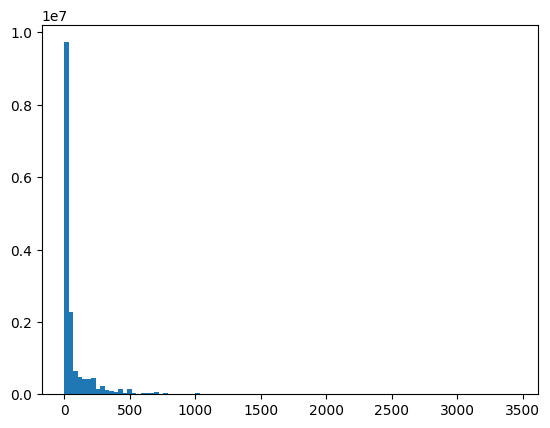

In [ ]:
print(data['zone_id'].value_counts())
plt.hist(data['zone_id'], bins=100)
plt.show()

Видим, что есть как и очень популярные зоны, так и очень редкие, встречающиеся по одному разу. По сути имеем категориальную фичу с большим количеством категорий, нужно будет применить техники уменьшения размерности, например, hashing trick

In [ ]:
for value, count in data['zone_id'].value_counts().items():
  print(f"id = {value}, count = {count}")

##banner_id

22      613230
361     387324
3       286891
18      262848
21      246069
         ...  
1501         1
1503         1
1504         1
1507         1
1632         1
Name: banner_id, Length: 1633, dtype: int64


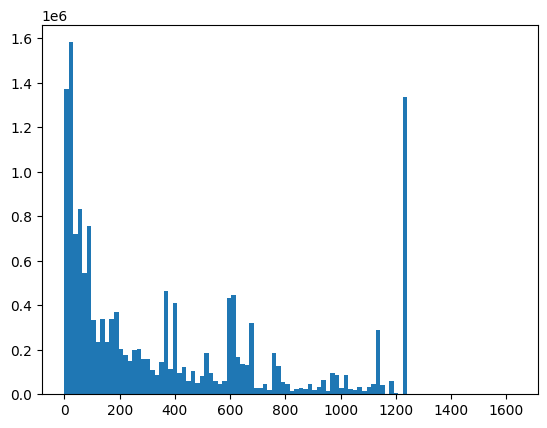

In [ ]:
print(data['banner_id'].value_counts())
plt.hist(data['banner_id'], bins=100)
plt.show()

Тут тоже видим редкие banner_id.

In [ ]:
for value, count in data['banner_id'].value_counts().items():
  print(f"id = {value}, count = {count}")

0      13674351
1       1236020
2        342680
3        173411
4        100219
         ...   
791           1
829           1
820           1
803           1
828           1
Name: campaign_clicks, Length: 822, dtype: int64


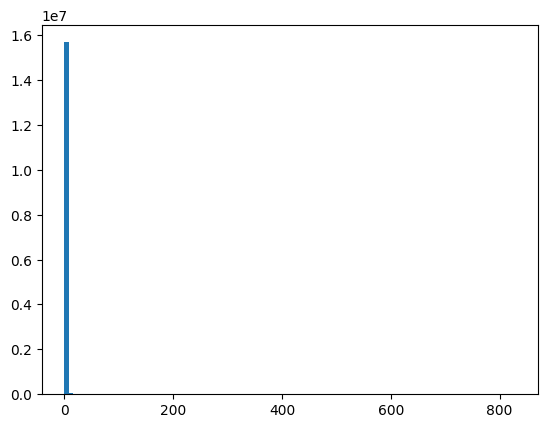

In [ ]:
print(data['campaign_clicks'].value_counts())
plt.hist(data['campaign_clicks'], bins=100)
plt.show()

Это числовая, а не категориальная фича, нужно нормализовать ее

##os_id

In [ ]:
data['os_id'].value_counts()

2     4585585
0     3855517
1     3177765
4     3011011
3      758593
6      310110
5      111859
8        1272
7          99
9          25
10          5
Name: os_id, dtype: int64

Видим, что это категориальная фича c маленьким количеством фичей.Применим one-hot-encoding. Можно объединить 7, 8, 9, 10 лейблы в одну
категорию 'other', так как для них примеров значительно меньше, чем для остальных категорий.

##country_id

In [ ]:
data['country_id'].value_counts()

0     4953404
5     1908101
6     1581894
7     1524483
1     1345737
3     1336892
15     602956
12     477813
9      438747
4      388714
10     356178
11     212106
8      210086
13     190786
14     138313
16      79113
2       66518
Name: country_id, dtype: int64

Тоже категориальная фича => one-hot-encoding

##date_time

In [43]:
#смотрим, как данные распределены по отдельным дням
pd.to_datetime(data['date_time']).dt.date.value_counts()

2021-09-26    3095582
2021-09-29    2418391
2021-09-27    2362615
2021-09-28    2304751
2021-10-02    2122891
2021-09-30    1846178
2021-10-01    1641688
2021-09-01          1
Name: date_time, dtype: int64

Видим, что последняя дата 2021-09-01 явно лишняя в выборке и попала сюда как-то случайно, так как остальные даты идут последовательно друг за другом, уберем этот пример из датасета.

In [9]:
#фильтруем выброс
data = data[data['date_time'] > '2021-09-01']

In [10]:
#добавляем колонку дата показа
data['date'] = pd.to_datetime(data['date_time']).dt.date

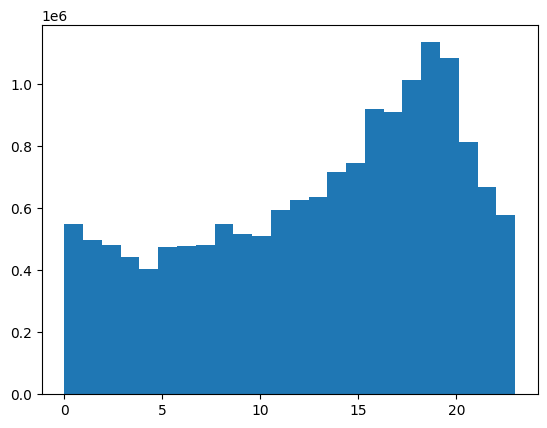

In [48]:
#смотрим, как данные распределены по отдельным часам
pd.to_datetime(data['date_time']).dt.hour.value_counts()
plt.hist(pd.to_datetime(data['date_time']).dt.hour, bins=24)
plt.show()

Мне кажется, есть смысл попробовать взять в качестве фичи время, в которое была показана реклама, потому что поведение человека меняется в течение дня, что влияет на контент, который ему интересен в текущий момент (например, в среднем,днем люди заняты работой или учебой, а вечером и ночью они отдыхают, просматривают соцсети и тд => с большей вероятностью кликнут на заинтересовавшую их рекламу)

In [11]:
#добавляем колонку время показа
data['hour'] = pd.to_datetime(data['date_time']).dt.hour

In [12]:
#убираем колонку date_time
data.drop(columns = ['date_time'], inplace=True)

## oaid_hash

308174966294367527     5243
2890718152668627077    2511
2521895603443866206    2254
8212556321845734673    1974
3375698397737628939    1959
                       ... 
9108107090229728286       1
443212642642848410        1
8787149787557120223       1
7907202475581442443       1
453968700792456599        1
Name: oaid_hash, Length: 6510316, dtype: int64


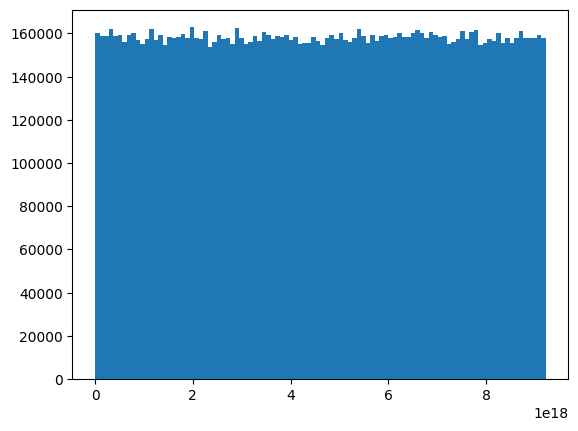

In [23]:
print(data['oaid_hash'].value_counts())
plt.hist(data['oaid_hash'], bins=100)
plt.show()

## g0 и g1 - стандартные отклонения

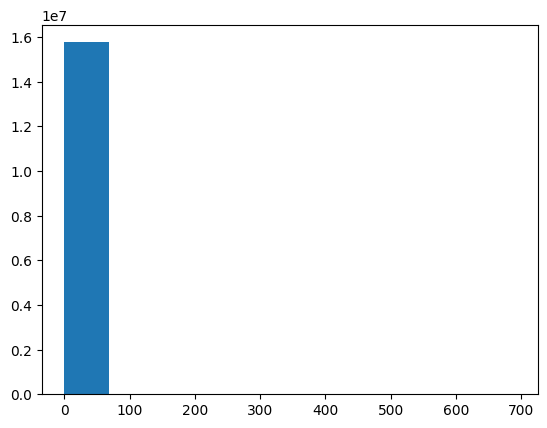

In [59]:
plt.hist(data['g0'], bins=10)
plt.show()

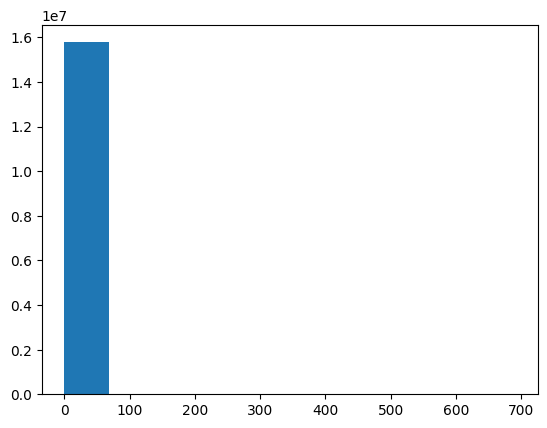

In [60]:
plt.hist(data['g1'], bins=10)
plt.show()

##correlation matrix
На всякий случай, проверим, что у нас нет явной коррелирующих фичей

In [13]:
data.corr()

<ipython-input-13-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,zone_id,banner_id,oaid_hash,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,clicks,hour
zone_id,1.000000,-0.035966,-0.003782,0.003906,0.145423,-0.010412,-0.005160,0.039482,0.037682,-0.007068,-0.016703,0.039376,0.042875,-0.024045,0.054150
banner_id,-0.035966,1.000000,0.000633,0.041216,-0.126151,-0.082290,0.002299,0.029866,-0.352541,-0.084731,-0.005866,0.020978,-0.257455,-0.050575,-0.054704
oaid_hash,-0.003782,0.000633,1.000000,-0.001375,-0.001422,0.001251,0.000440,-0.000238,-0.000168,0.001747,0.000903,-0.000184,-0.000126,0.000335,-0.001145
os_id,0.003906,0.041216,-0.001375,1.000000,0.039507,-0.004306,0.013647,-0.024700,0.142504,0.075067,0.036169,-0.023759,0.108331,0.039757,-0.015301
country_id,0.145423,-0.126151,-0.001422,0.039507,1.000000,0.047013,-0.008307,0.010034,0.173660,-0.028146,-0.011223,0.009256,0.139835,-0.004668,0.186562
banner_id0,-0.010412,-0.082290,0.001251,-0.004306,0.047013,1.000000,0.259994,-0.010557,0.417413,-0.115947,-0.040071,-0.002822,-0.051097,0.001838,0.061577
rate0,-0.005160,0.002299,0.000440,0.013647,-0.008307,0.259994,1.000000,-0.002943,0.042873,-0.029286,-0.010629,0.000645,-0.003775,-0.000872,0.008435
g0,0.039482,0.029866,-0.000238,-0.024700,0.010034,-0.010557,-0.002943,1.000000,0.015144,-0.006082,-0.002103,0.760437,0.016704,0.001553,0.019768
coeff_sum0,0.037682,-0.352541,-0.000168,0.142504,0.173660,0.417413,0.042873,0.015144,1.000000,0.000569,-0.003181,0.014123,0.495136,0.118360,0.102454
banner_id1,-0.007068,-0.084731,0.001747,0.075067,-0.028146,-0.115947,-0.029286,-0.006082,0.000569,1.000000,0.322065,-0.017762,0.475516,-0.009247,0.008470


видим, что коэффициенты корреляции довольно маленькие, поэтому между фичами нет какой-то явной линейно зависимости => можно брать все фичи.

#Feature engineering


In [14]:
#разделим данные на обучающую и тестовую выборки
test_date = data['date'].max()
train_data = data[data['date'] != test_date]
test_data = data[data['date'] == test_date]
#по условию для подсчета полиси нужно отфильтровать случаи, когда banner_id != banner_id0
test_data_0 = test_data[test_data['banner_id'] == test_data['banner_id0']]

#нам еще нужен датасет, в котором banner_id == banner_id1, чтобы корректно посчитать p_1
test_data_1 = test_data_0.copy()
test_data_1['banner_id'] = test_data_1['banner_id1']

print(len(train_data))
print(len(test_data_0))
print(len(test_data_1))

13669206
1884528
1884528


In [15]:
y_train = train_data['clicks']
X_train = train_data.drop(columns=['clicks', 'date'])

In [16]:
y_test = test_data_0['clicks']
X_test_0 = test_data_0.drop(columns=['clicks', 'date'])
X_test_1 = test_data_1.drop(columns=['clicks', 'date'])

In [17]:
#применяем обычный one-hot-encoding к категориальным фичам
from sklearn.preprocessing import OneHotEncoder

categories = ['os_id', 'country_id', 'zone_id', 'banner_id']

one_hot_enc = OneHotEncoder(
    sparse_output=True,
    handle_unknown='ignore'
    )

X_train_categorical = one_hot_enc.fit_transform(X_train[categories])
X_test_0_categorical = one_hot_enc.transform(X_test_0[categories])
X_test_1_categorical = one_hot_enc.transform(X_test_1[categories])

In [18]:
X_train_numerical = X_train[['hour']]
X_test_numerical = X_test_0[['hour']]

In [19]:
from scipy.sparse import hstack

X_train = hstack([X_train_categorical, X_train_numerical])
X_test_0 = hstack([X_test_0_categorical, X_test_numerical])
X_test_1 = hstack([X_test_1_categorical, X_test_numerical])

#Обучение модели

В качестве модели возьмем логистическую регрессию с l2-регуляризацией

In [20]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    solver = 'liblinear'
)

In [21]:
model = model.fit(X_train, y_train)

#Подсчет OPE метрики clipped ips на последнем дне.

\pi_0
В данной задаче предполагается, что логгинг полиси это некоторая стохастическая полиси. В каждом событии соревновались два баннера. Победивший баннер это всегда banner_id0, а проигравший это banner_id1. В итоге banner_id0 это именно тот баннер, который был показан пользователю. banner_id0 совпадает почти всегда совпадает с banner_id, но есть случаи когда это не так, их стоит отфильтровать. Победитель в каждом событии определялся случайно согласно следующей логике:

Подкидывались две нормальные величины N(coeff_sum0, g0^2) и N(coeff_sum1, g1^2)
Выбирался тот баннер чей семпл получался больше.
На оснований этих данных вы можете посчитать \pi_0, для этого вам достаточно только в каждом событии определить вероятность того, что одна нормальная величина больше другой.



$X_0 \sim N(coeff\_ sum0, g0^2)$

$X_1 \sim N(coeff\_ sum1, g1^2)$

$P(X_0 > X_1) = P(X_ 0 - X_1 > 0) = 1 - P(X_0 - X_1 \leq 0) = 1 - F_{X_0 - X_1}(0)$,

где  
$X_0 - X_1 \sim N(coeff\_ sum0 - coeff\_ sum1, g0^2 + g1^2)$

In [24]:
from scipy.stats import norm

#считаем по формуле выше
def policy(coeff_sum0, coeff_sum1, g0, g1):
  mean = coeff_sum0 - coeff_sum1
  sd = np.sqrt(g0 ** 2 + g1 ** 2)
  eps = np.finfo(np.float32).eps #чтобы не было деления на 0
  F_0 = norm.cdf(0, loc=mean, scale=sd + eps)
  return 1 - F_0

In [25]:
coeff_sum0 = test_data_0['coeff_sum0']
coeff_sum1 = test_data_0['coeff_sum1']
g0 = test_data_0['g0']
g1 = test_data_0['g1']

pi_0 = policy(coeff_sum0, coeff_sum1, g0, g1)

\pi_1
Здесь вы предполагаете что новое полиси в целом работает примерно также. Подкидывается N(coeff_sum0_new, g0^2) и N(coeff_sum1_new, g1^2). Где coeff_sum0_new и coeff_sum1_new суммы коэффициентов для banner_id0 и banner_id1, которые предиктит ваша модель. Вы можете их получить если примените logit функцию к вероятностям которые предиктит ваша модель.

Важный момент. Те предикты которые у вас уже имеются, они работают для banner_id0, потому что он совпадает с banner_id. Но вам еще нужно получить предикты для banner_id1. Для этого следует подставить в тест сете вместо banner_id значение banner_id1.

После получения coeff_sum0_new и coeff_sum1_new ваша задача опять сводится к сравнению нормальных величин.

In [26]:
from scipy.special import logit

coeff_sum0_new = logit(model.predict_proba(X_test_0))[:, 1]
coeff_sum1_new = logit(model.predict_proba(X_test_1))[:, 1]
g0 = test_data_0['g0']
g1 = test_data_0['g1']

pi_1 = policy(coeff_sum0_new, coeff_sum1_new, g0, g1)

In [31]:
lmbda = 10
r = test_data_0['clicks'] # по условию reward = 1, если был клик, и 0 - иначе
eps = np.finfo(np.float32).eps # чтобы не было деления на 0

cips = np.mean(r * np.clip(pi_0 / (pi_1 + eps), a_min=None, a_max=lmbda))
print(f"CIPS = {cips}")

CIPS = 0.06182578976396382
